<a href="https://colab.research.google.com/github/Danieljoshua720/Electricity-demand-forecasting-AIML/blob/main/AIML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Attention
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
df=pd.read_csv('/content/powerdemand_5min_2021_to_2024_with weather.csv')

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
datetime,0
Power demand,0
temp,0
dwpt,0
rhum,0
wdir,540
wspd,0
pres,0
year,0


In [ ]:
df.head()

,Unnamed: 0,datetime,Power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,moving_avg_3
0,0,2021-01-01 00:30:00,2014.00,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,30,NaN
1,1,2021-01-01 00:35:00,2005.63,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,35,NaN
2,2,2021-01-01 00:40:00,1977.60,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,40,1999.076667
3,3,2021-01-01 00:45:00,1976.44,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,45,1986.556667
4,4,2021-01-01 00:50:00,1954.37,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,50,1969.470000


In [ ]:
df = df.drop(columns=['Unnamed: 0'])


In [ ]:

num_cols = ['wdir', 'pres', 'year', 'month', 'day', 'hour', 'minute', 'moving_avg_3']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())


In [ ]:
df.isnull().sum()

,0
datetime,0
Power demand,0
temp,0
dwpt,0
rhum,0
wdir,0
wspd,0
pres,0
year,0
month,0


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])


In [ ]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393440 entries, 0 to 393439
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   datetime      393440 non-null  datetime64[ns]
 1   Power demand  393440 non-null  float64       
 2   temp          393440 non-null  float64       
 3   dwpt          393440 non-null  float64       
 4   rhum          393440 non-null  float64       
 5   wdir          393440 non-null  float64       
 6   wspd          393440 non-null  float64       
 7   pres          393440 non-null  float64       
 8   year          393440 non-null  int32         
 9   month         393440 non-null  int32         
 10  day           393440 non-null  int32         
 11  hour          393440 non-null  int32         
 12  minute        393440 non-null  int32         
 13  moving_avg_3  393440 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int32(5)
memory usage: 34.5 MB


In [ ]:
X = df.drop(columns=['datetime', 'Power demand'])
y = df[['Power demand']]


In [ ]:
df.tail()

,datetime,Power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,moving_avg_3
393435,2024-12-12 00:10:00,2146.84,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,10,2174.893333
393436,2024-12-12 00:15:00,2116.66,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,15,2139.416667
393437,2024-12-12 00:20:00,2082.77,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,20,2115.423333
393438,2024-12-12 00:25:00,2059.17,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,25,2086.200000
393439,2024-12-12 00:30:00,2049.66,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,30,2063.866667


In [ ]:
train_size = int(0.8 * len(df))
val_size   = int(0.1 * len(df))

X_train = X[:train_size]
X_val   = X[train_size:train_size + val_size]
X_test  = X[train_size + val_size:]

y_train = y[:train_size]
y_val   = y[train_size:train_size + val_size]
y_test  = y[train_size + val_size:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)


In [ ]:
scaler_y = MinMaxScaler(feature_range=(0, 1))

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)


In [ ]:
import numpy as np

def create_sequences(X, y, time_steps=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)


In [ ]:
time_steps = 24  # you can adjust based on problem

X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_val_lstm, y_val_lstm     = create_sequences(X_val_scaled, y_val_scaled, time_steps)
X_test_lstm, y_test_lstm   = create_sequences(X_test_scaled, y_test_scaled, time_steps)


In [ ]:
print(X_train_lstm.shape)
print(y_train_lstm.shape)


(314728, 24, 12)
(314728, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 50)             │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,651 (49.42 KB)

 Trainable params: 12,651 (49.42 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Dictionary to store results
results = {}

# -------------------
# 1️⃣ Vanilla LSTM
# -------------------
vanilla_lstm = Sequential([
    LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
vanilla_lstm.compile(optimizer='adam', loss='mse')
vanilla_lstm.fit(X_train_lstm, y_train_lstm,
                  validation_data=(X_val_lstm, y_val_lstm),
                  epochs=10, batch_size=64, verbose=1)
y_pred_vanilla = vanilla_lstm.predict(X_test_lstm)
results['Vanilla'] = y_pred_vanilla

# -------------------
# 2️⃣ Stacked LSTM
# -------------------
stacked_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50),
    Dense(1)
])
stacked_lstm.compile(optimizer='adam', loss='mse')
stacked_lstm.fit(X_train_lstm, y_train_lstm,
                 validation_data=(X_val_lstm, y_val_lstm),
                 epochs=10, batch_size=64, verbose=1)
y_pred_stacked = stacked_lstm.predict(X_test_lstm)
results['Stacked'] = y_pred_stacked

# -------------------
# 3️⃣ LSTM + Dropout
# -------------------
lstm_dropout = Sequential([
    LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(1)
])
lstm_dropout.compile(optimizer='adam', loss='mse')
lstm_dropout.fit(X_train_lstm, y_train_lstm,
                 validation_data=(X_val_lstm, y_val_lstm),
                 epochs=10, batch_size=64, verbose=1)
y_pred_dropout = lstm_dropout.predict(X_test_lstm)
results['Dropout'] = y_pred_dropout

# -------------------
# 4️⃣ Bidirectional LSTM
# -------------------
bidir_lstm = Sequential([
    Bidirectional(LSTM(50), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
bidir_lstm.compile(optimizer='adam', loss='mse')
bidir_lstm.fit(X_train_lstm, y_train_lstm,
               validation_data=(X_val_lstm, y_val_lstm),
               epochs=10, batch_size=64, verbose=1)
y_pred_bidir = bidir_lstm.predict(X_test_lstm)
results['Bidirectional'] = y_pred_bidir

# -------------------
# 5️⃣ CNN + LSTM
# -------------------
cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50),
    Dense(1)
])
cnn_lstm.compile(optimizer='adam', loss='mse')
cnn_lstm.fit(X_train_lstm, y_train_lstm,
             validation_data=(X_val_lstm, y_val_lstm),
             epochs=10, batch_size=64, verbose=1)
y_pred_cnn = cnn_lstm.predict(X_test_lstm)
results['CNN-LSTM'] = y_pred_cnn


Epoch 1/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 67s 13ms/step - loss: 0.0056 - val_loss: 5.5655e-04
Epoch 2/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 68s 14ms/step - loss: 1.8990e-04 - val_loss: 2.2255e-04
Epoch 3/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - loss: 1.6432e-04 - val_loss: 2.1081e-04
Epoch 4/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 1.4578e-04 - val_loss: 1.7248e-04
Epoch 5/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - loss: 1.2078e-04 - val_loss: 1.6925e-04
Epoch 6/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 1.1858e-04 - val_loss: 1.6768e-04
Epoch 7/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - loss: 1.1011e-04 - val_loss: 1.7881e-04
Epoch 8/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 67s 14ms/step - loss: 1.1894e-04 - val_loss: 1.8501e-04
Epoch 9/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - loss: 1.0777e-04 - val_loss: 1.6586e-04
Epoch 10/10
4918/4918 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - loss: 1.0847e-04 - val_loss: 1.9205e-04
1229/1229 ━━━━━━━━━━━━━

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def run_all_15_tests(
    model,
    history,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
):
    results = {}

    # Predictions
    y_train_pred = model.predict(X_train, verbose=0).reshape(-1)
    y_val_pred   = model.predict(X_val, verbose=0).reshape(-1)
    y_test_pred  = model.predict(X_test, verbose=0).reshape(-1)

    y_train = np.array(y_train).reshape(-1)
    y_val   = np.array(y_val).reshape(-1)
    y_test  = np.array(y_test).reshape(-1)

    # Error Metrics
    results["Train_MSE"] = mean_squared_error(y_train, y_train_pred)
    results["Val_MSE"]   = mean_squared_error(y_val, y_val_pred)
    results["Test_MSE"]  = mean_squared_error(y_test, y_test_pred)

    results["Train_RMSE"] = np.sqrt(results["Train_MSE"])
    results["Val_RMSE"]   = np.sqrt(results["Val_MSE"])
    results["Test_RMSE"]  = np.sqrt(results["Test_MSE"])

    results["Train_MAE"] = mean_absolute_error(y_train, y_train_pred)
    results["Val_MAE"]   = mean_absolute_error(y_val, y_val_pred)
    results["Test_MAE"]  = mean_absolute_error(y_test, y_test_pred)

    # Percentage Errors
    eps = 1e-8
    results["MAPE"] = np.mean(np.abs((y_test - y_test_pred) / (y_test + eps))) * 100
    results["sMAPE"] = np.mean(
        2 * np.abs(y_test - y_test_pred) /
        (np.abs(y_test) + np.abs(y_test_pred) + eps)
    ) * 100

    # Generalization
    results["Overfitting_Gap"] = results["Val_MSE"] - results["Train_MSE"]
    results["Robustness_Ratio"] = (
        results["Val_MSE"] / results["Test_MSE"]
        if results["Test_MSE"] != 0 else np.nan
    )

    # Stability (safe)
    if history is not None and "val_loss" in history.history:
        val_losses = history.history["val_loss"]
        results["Stability_Score"] = np.std(val_losses[-3:])
        results["Best_Epoch"] = np.argmin(val_losses) + 1
    else:
        results["Stability_Score"] = np.nan
        results["Best_Epoch"] = np.nan

    # Model size
    results["Total_Params"] = model.count_params()

    return results

In [ ]:
models = {
    "Vanilla LSTM": vanilla_lstm,
    "Stacked LSTM": stacked_lstm,
    "Dropout LSTM": lstm_dropout,
    "Bidirectional LSTM": bidir_lstm,
    "CNN-LSTM": cnn_lstm
}

all_results = {}

for name, model in models.items():
    print(f"\n================ {name} =================")

    results = run_all_15_tests(
        model, None,
        X_train_lstm, y_train_lstm,
        X_val_lstm, y_val_lstm,
        X_test_lstm, y_test_lstm
    )

    all_results[name] = results

    for k, v in results.items():
        print(f"{k:20s}: {v}")



================ Vanilla LSTM =================
Train_MSE           : 0.00010690864065148186
Val_MSE             : 0.00016573341081895293
Test_MSE            : 0.00010894858341843798
Train_RMSE          : 0.010339663468966573
Val_RMSE            : 0.012873748903056675
Test_RMSE           : 0.010437843810789563
Train_MAE           : 0.003528652812253708
Val_MAE             : 0.0042174967484785945
Test_MAE            : 0.003989525780327388
MAPE                : 1.017089601762409
sMAPE               : 0.9907287324272886
Overfitting_Gap     : 5.8824770167471076e-05
Robustness_Ratio    : 1.5212075790138722
Stability_Score     : nan
Best_Epoch          : nan
Total_Params        : 12651

================ Stacked LSTM =================
Train_MSE           : 0.00024463684461277523
Val_MSE             : 0.00031922620508669576
Test_MSE            : 0.00032980534901629147
Train_RMSE          : 0.015640870967205605
Val_RMSE            : 0.017866902503979133
Test_RMSE           : 0.0181605437423082

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Collect results in one dictionary
all_results = {
    "Vanilla": vanilla_results,
    "Stacked": stacked_results,
    "Dropout": dropout_results,
    "Bidirectional": bidir_results,
    "CNN-LSTM": cnn_results
}

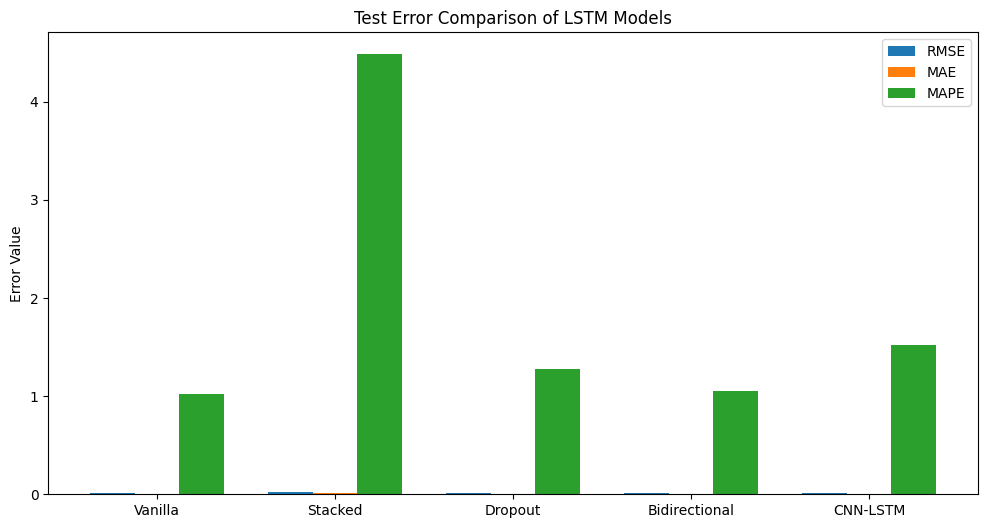

In [ ]:
models = list(all_results.keys())
rmse = [all_results[m]['Test_RMSE'] for m in models]
mae  = [all_results[m]['Test_MAE'] for m in models]
mape = [all_results[m]['MAPE'] for m in models]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(12,6))
plt.bar(x - width, rmse, width, label='RMSE')
plt.bar(x, mae, width, label='MAE')
plt.bar(x + width, mape, width, label='MAPE')
plt.xticks(x, models)
plt.ylabel('Error Value')
plt.title('Test Error Comparison of LSTM Models')
plt.legend()
plt.show()

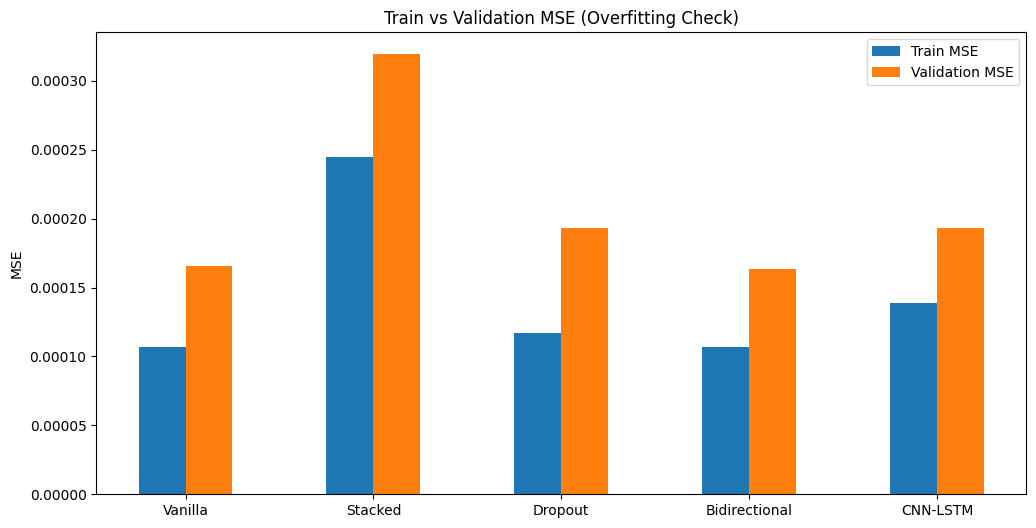

In [ ]:
train_mse = [all_results[m]['Train_MSE'] for m in models]
val_mse   = [all_results[m]['Val_MSE'] for m in models]

plt.figure(figsize=(12,6))
plt.bar(x - width/2, train_mse, width, label='Train MSE')
plt.bar(x + width/2, val_mse, width, label='Validation MSE')
plt.xticks(x, models)
plt.ylabel('MSE')
plt.title('Train vs Validation MSE (Overfitting Check)')
plt.legend()
plt.show()


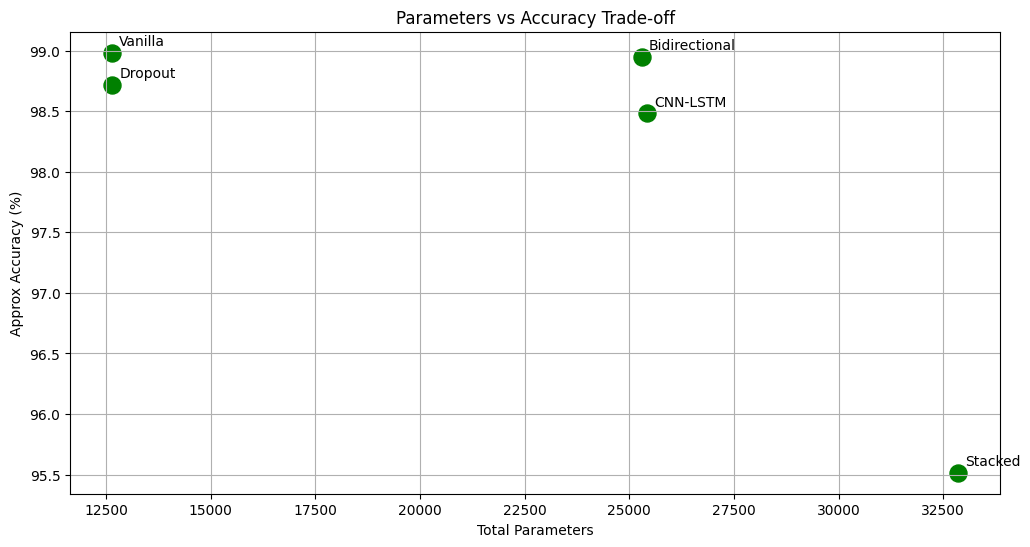

In [ ]:
params = [all_results[m]['Total_Params'] for m in models]
accuracy = [100 - all_results[m]['MAPE'] for m in models]  # approx accuracy

plt.figure(figsize=(12,6))
plt.scatter(params, accuracy, s=150, c='green')
for i, txt in enumerate(models):
    plt.annotate(txt, (params[i], accuracy[i]), xytext=(5,5), textcoords='offset points')
plt.xlabel('Total Parameters')
plt.ylabel('Approx Accuracy (%)')
plt.title('Parameters vs Accuracy Trade-off')
plt.grid(True)
plt.show()
